In [1]:
from mace.calculators import mace_mp
from ase import build

from ase.md import Langevin
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units
from ase import io
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "serif",       
    "font.size": 12,              
    "axes.labelsize": 14,         
    "axes.titlesize": 16,         
    "xtick.labelsize": 12,        
    "ytick.labelsize": 12,       
    "legend.fontsize": 12,      
    "text.usetex": True       
})


macemp0 = mace_mp(dispersion=True, default_dtype="float64", model="medium")
macemp = mace_mp(dispersion=True, default_dtype="float64")
macemp_omat = mace_mp(model="/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/mace-omat-0-medium.model", dispersion=True, default_dtype="float64")

/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/venv_mace/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
Using Materials Project MACE for MACECalculator with /Users/joehart/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using TorchDFTD3Calculator for D3 dispersion corrections
Using medium MPA-0 model as default MACE-MP model, to use previous (before 3.10) default model please specify 'medium' as model argument
Using Materials Project MACE for MACECalculator with /Users/joehart/.cache/mace/macempa0mediummodel
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/venv_mace/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/venv_mace/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using TorchDFTD3Calculator for D3 dispersion corrections
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using TorchDFTD3Calculator for D3 dispersion corrections


/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/venv_mace/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


In [2]:
import warnings
from copy import deepcopy
from pathlib import Path
from typing import Any, Callable
from functools import partial

import numpy as np
from ase import Atoms
from ase.calculators.calculator import Calculator
from tqdm import tqdm
from phonopy.api_phonopy import Phonopy
from phonopy.api_gruneisen import PhonopyGruneisen
from phonopy.phonon.thermal_properties import mode_cv
from phonopy.units import EvTokJmol, THzToEv
from phonopy.api_qha import PhonopyQHA


# from mlp_phonopy.phonopy_utils import aseatoms2phonopy, get_chemical_formula, load_phonopy
# from mlp_phonopy.utils import MODE_KAPPA_THRESHOLD, log_message, scale_atoms_volume, aseatoms2str
# from mlp_phonopy.relax import simple_relax

FREQ_CUTOFF = 1e-3

def calculate_fc2_phonopy_set(
    phonons: Phonopy,
    calculator: Calculator,
    log: bool = True,
    pbar_kwargs: dict[str, Any] = {},
) -> np.ndarray:
    # calculate FC2 force set

    #log_message(f"Computing FC2 force set in {get_chemical_formula(phonons)}.", output=log)

    forces = []
    nat = len(phonons.supercell)

    for sc in tqdm(
        phonons.supercells_with_displacements,
        desc=f"FC2 calculation: {get_chemical_formula(phonons)}",
        **pbar_kwargs,
    ):
        if sc is not None:
            atoms = Atoms(sc.symbols, cell=sc.cell, positions=sc.positions, pbc=True)
            atoms.calc = calculator
            f = atoms.get_forces()
        else:
            f = np.zeros((nat, 3))
        forces.append(f)

    # append forces
    force_set = np.array(forces)
    phonons.forces = force_set
    return force_set



def init_phonopy(
    atoms: Atoms,
    fc2_supercell: np.ndarray | None = None,  
    primitive_matrix: Any = "auto",
    log: str | Path | bool = True,
    symprec: float = 1e-5,
    displacement_distance: float = 0.03,
    **kwargs: Any,
) -> tuple[Phonopy, list[Any]]:
    """Calculate fc2 and fc3 force lists from phonopy.

    """
    if not log:
        log_level = 0
    elif log is not None:
        log_level = 1

    if fc2_supercell is not None :
        _fc2_supercell = fc2_supercell
    else:
        if "fc2_supercell" in atoms.info.keys() :
            _fc2_supercell = atoms.info["fc2_supercell"]
        else:
            raise ValueError(f'{atoms.get_chemical_formula(mode="metal")=} "fc2_supercell" was not found in atoms.info and was not provided as an argument when calculating force sets.')


    # Initialise Phonopy object
    phonons = aseatoms2phonopy(
        atoms,
        fc2_supercell=_fc2_supercell,
        primitive_matrix=primitive_matrix,
        symprec=symprec,
        log_level=log_level,
        **kwargs,
    )

    phonons.generate_displacements(distance=displacement_distance)

    return phonons


def get_fc2_and_freqs(
    phonons: Phonopy,
    calculator: Calculator | None = None,
    q_mesh : np.ndarray | None = None,
    symmetrize_fc2 = True,
    log: str | Path | bool = True,
    pbar_kwargs: dict[str, Any] = {"leave": False},
    **kwargs: Any,
) -> tuple[Phonopy, np.ndarray, np.ndarray]:
   

    if calculator is None:
        raise ValueError(
            f'{get_chemical_formula(phonons)} "calculator" was provided when calculating fc2 force sets.'
        )

    fc2_set = calculate_fc2_phonopy_set(phonons, calculator, log=log, pbar_kwargs=pbar_kwargs)

    phonons.produce_force_constants(show_drift=False)
    
    if symmetrize_fc2:
        phonons.symmetrize_force_constants(show_drift=False)
    
    if q_mesh is not None:
        phonons.run_mesh(q_mesh, **kwargs)
        freqs= phonons.get_mesh_dict()["frequencies"]
    else:
        freqs=[]

    return phonons, fc2_set, freqs




def load_force_sets(
    phonons: Phonopy, fc2_set: np.ndarray
) -> Phonopy:
    phonons.forces = fc2_set
    phonons.produce_force_constants(symmetrize_fc2=True)
    return phonons


# some helper functions:

from phonopy.structure.atoms import PhonopyAtoms
from phonopy.api_phonopy import Phonopy
from ase import Atoms

def aseatoms2phonoatoms(atoms):
    phonoatoms = PhonopyAtoms(
        atoms.symbols, cell=atoms.cell, positions=atoms.positions, pbc=True
    )
    return phonoatoms

def phonoatoms2aseatoms(phonoatoms):
    atoms = Atoms(
        phonoatoms.symbols, cell=phonoatoms.cell, positions=phonoatoms.positions, pbc=True
    )
    return atoms


def aseatoms2phonopy(
    atoms, fc2_supercell, primitive_matrix=None, nac_params=None, symprec=1e-5,**kwargs
) -> Phonopy:
    unitcell = aseatoms2phonoatoms(atoms)
    return Phonopy(
        unitcell=unitcell,
        supercell_matrix=fc2_supercell,
        primitive_matrix=primitive_matrix,
        nac_params = nac_params,
        symprec=symprec,
        **kwargs,
    )

def phonopy2aseatoms(phonons: Phonopy) -> Atoms:
    phonopy_atoms = phonons.unitcell
    atoms = Atoms(
        phonopy_atoms.symbols,
        cell=phonopy_atoms.cell,
        positions=phonopy_atoms.positions,
        pbc=True,
    )

    if phonons.supercell_matrix is not None:
        atoms.info["fc2_supercell"] = phonons.supercell_matrix

    if phonons.primitive_matrix is not None:
        atoms.info["primitive_matrix"] = phonons.primitive_matrix

    if phonons.mesh_numbers is not None:
        atoms.info["q_mesh"] = phonons.mesh_numbers

    return atoms


def get_chemical_formula(phonons: Phonopy, mode="metal", **kwargs):
    unitcell = phonons.unitcell
    atoms = Atoms(
        unitcell.symbols, cell=unitcell.cell, positions=unitcell.positions, pbc=True
    )
    return atoms.get_chemical_formula(mode=mode, **kwargs)

def load_phonopy(yaml_file, **kwargs):
    from phonopy.cui.load import load
    return load(yaml_file, **kwargs)

### Calc phonons and PhDOS

In [127]:
import numpy as np
from ase import Atoms
from phonopy.api_phonopy import Phonopy
from phonopy.phonon.band_structure import get_band_qpoints_and_path_connections

def compute_ph_phdos(atoms, N_supercell, calc, sigma_dos=0.2):
    phonons = init_phonopy(
        atoms=atoms,
        fc2_supercell=np.diag([N_supercell, N_supercell, 1]), 
        primitive_matrix="auto",
        displacement_distance=0.05,
        symprec=1e-5
    )

    npoints = 300
    
    # Compute force constants and phonon frequencies
    phonons, fc2_set, freqs = get_fc2_and_freqs(
        phonons=phonons,
        calculator=calc,
        q_mesh=np.array([npoints, npoints, 1]),  # q-mesh density
        symmetrize_fc2=True # symmetrize force constants
    )

    special_points = {
        'Γ': [0.0, 0.0, 0.0],  
        'M': [0.5, 0.0, 0.0],  
        'K': [1/3, 1/3, 0.0],  
    }
    path = [[special_points['Γ'], special_points['M'], special_points['K'], special_points['Γ']]]
    labels = ["$\\Gamma$", "M", "K", "$\\Gamma$"]


    qpoints, connections = get_band_qpoints_and_path_connections(path, npoints=npoints)

    # phonon band strucutre
    phonons.run_band_structure(qpoints, path_connections=connections, labels=labels)
    #phonons.plot_band_structure().show()

    #check for imaginary frequencies
    mesh_data = phonons.get_mesh_dict()
    frequencies = mesh_data["frequencies"]
    min_freq = np.min(frequencies)
    if min_freq < -0.1:
        print(f"Warning: Imaginary frequency detected! Min Frequency = {min_freq} THz")
    else:
        print(f"All frequencies are real. Min Frequency = {min_freq} THz")
        

    phonons.run_mesh([20, 20, 1], is_mesh_symmetry=False)
    phonons.run_total_dos(sigma=sigma_dos)

    #phonons.plot_total_dos().show()
    return phonons


### Plot phonons and PhDOS

In [204]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c

def plot_ph_phdos(phonons, model, xlim_dos, ref_ph=None, ref_phdos=None, ylim=(0, 25), xticks_dos=None, filepath=None):

    band_data = phonons.get_band_structure_dict()
    q_distances = band_data["distances"]  # X-axis distances along the path (list of arrays)
    frequencies = band_data["frequencies"]  # Y-axis: Phonon frequencies (list of arrays)

    dos_data = phonons.get_total_dos_dict()
    dos_freqs = dos_data["frequency_points"]  # X-axis: Frequency (THz)
    dos_values = dos_data["total_dos"]  # Y-axis: Total DOS


    fig = plt.figure(figsize=(7, 4))


    special_points = ['$\Gamma$', 'M', 'K', '$\Gamma$']
    special_distances = [q_distances[0][0]] + [qd[-1] for qd in q_distances]  # Get special point positions


    ax1 = fig.add_axes([0.12, 0.07, 0.67, 0.85])  # Main band structure plot
    ax1.vlines([q_distances[0][-1], q_distances[1][-1]], 0, 100, color="k", ls="-", lw=1)



    for q_segment, freq_segment in zip(q_distances, frequencies):
        for band in freq_segment.T:  # T to get individual phonon branches
            ax1.plot(q_segment, band, color="blue", lw=1, zorder = 2)

    if ref_ph:
        # normalise x
        q_min = q_distances[0][0]
        q_max = q_distances[-1][-1]        
        
        cm_1_to_THz = c * 100 * 1e-12
        for mode in range(len(ref_ph[0])):  
            extracted_y = np.array(ref_ph[1][mode])
            
            x_norm = q_min + (np.array(np.array(ref_ph[0][mode])) - 0) * (q_max - q_min) / 300
            #ax1.scatter(x_norm, extracted_y_THz, color="red", label="Extracted Data" if mode == 0 else "", s=2)
            ax1.plot(x_norm, extracted_y, color="red", linestyle="--", lw=1, zorder=1)

    ax1.set_ylabel("Frequency THz")
    ax1.set_xlim(q_distances[0][0], q_distances[-1][-1])
    ax1.set_xticks([])
    #ax1.grid(True)
    ax1.set_ylim(0,20)

    ax1.set_xticks(special_distances)
    ax1.set_xticklabels(special_points)


    ax2 = fig.add_axes([0.82, 0.07, 0.17, 0.85])  # DOS plot on the right

    #ax2.fill_between(dos_values, dos_freqs, y2=0, color="green", edgecolor="green", lw=1)
    ax2.plot(dos_values, dos_freqs, color="blue", lw=1, label = model)
    
    if ref_phdos:
        ref_dos_x = ref_phdos[0]
        ref_dos_y = ref_phdos[1]
        plt.plot(ref_dos_x, ref_dos_y, color="red", lw=1, linestyle="--", label="PBE")



    ax2.set_ylim(0, np.max(frequencies))
    ax2.set_xticks(xticks_dos)
    ax2.set_xlim(xlim_dos)
    ax2.set_yticks([])
    #ax2.set_xticks([])
    ax2.set_xlabel("PhDOS")
    

    ax1.set_ylim(ylim)
    ax2.set_ylim(ylim)

    fig.legend(loc='upper center', ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.02))
    plt.tight_layout()
    plt.show()
    
    if filepath:
        fig.savefig(filepath, dpi=500, bbox_inches='tight')

    
    return


<>:19: SyntaxWarning: invalid escape sequence '\G'
<>:19: SyntaxWarning: invalid escape sequence '\G'
<>:19: SyntaxWarning: invalid escape sequence '\G'
<>:19: SyntaxWarning: invalid escape sequence '\G'
/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_18527/3267515824.py:19: SyntaxWarning: invalid escape sequence '\G'
  special_points = ['$\Gamma$', 'M', 'K', '$\Gamma$']
/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_18527/3267515824.py:19: SyntaxWarning: invalid escape sequence '\G'
  special_points = ['$\Gamma$', 'M', 'K', '$\Gamma$']


### MXene reference data: Phonons

In [5]:
special_points = {
    'Γ': [0.0, 0.0, 0.0],   # Gamma
    'M': [0.5, 0.0, 0.0],   # M point
    'K': [1/3, 1/3, 0.0],   # K point
}

npoints = 300   # Number of points in the band structure
delta = 0.05

path_segments = ['Γ', 'M', 'K', 'Γ']
path_labels = ['$\Gamma$', 'M', 'K', '$\Gamma$']


<>:11: SyntaxWarning: invalid escape sequence '\G'
<>:11: SyntaxWarning: invalid escape sequence '\G'
<>:11: SyntaxWarning: invalid escape sequence '\G'
<>:11: SyntaxWarning: invalid escape sequence '\G'
/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_18527/345495617.py:11: SyntaxWarning: invalid escape sequence '\G'
  path_labels = ['$\Gamma$', 'M', 'K', '$\Gamma$']
/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_18527/345495617.py:11: SyntaxWarning: invalid escape sequence '\G'
  path_labels = ['$\Gamma$', 'M', 'K', '$\Gamma$']


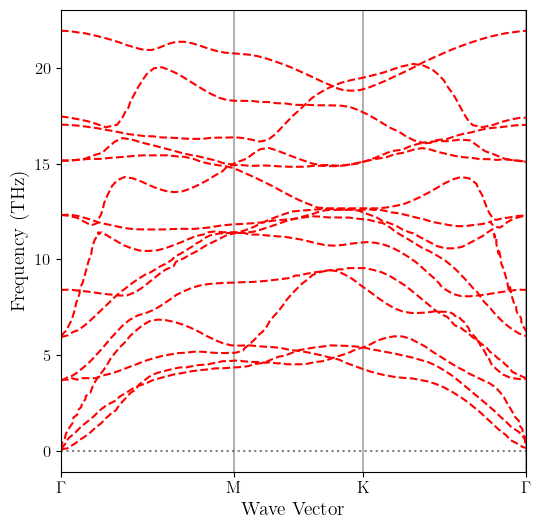

In [113]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import glob
from scipy.constants import c

# load all ph_mode files (extracted with plot digitiser)
file_pattern = "reference_ph_modes/2ph_mode*.json"
files = sorted(glob.glob(file_pattern), key=lambda x: int(x.split("2ph_mode")[-1].split(".json")[0]))

data = []

for file in files:
    with open(file, 'r') as f:
        data.append(json.load(f))

values_x_mxnene = []
values_y_mxene = []

for dat in data:
    values_x_mxnene.append([i['value'][0] for i in dat['datasetColl'][0]['data']])
    values_y_mxene.append([i['value'][1] for i in dat['datasetColl'][0]['data']])
    
# convert to THz
cm_1_to_THz = c * 100 * 1e-12
values_y = [[y * cm_1_to_THz for y in band] for band in values_y_mxene]

x_min = [min(band) for band in values_x_mxnene]
x_max = [max(band) for band in values_x_mxnene]
    

x_norm = [
    [(x - band_min) / (band_max - band_min) * npoints for x in band]
    for band, band_min, band_max in zip(values_x_mxnene, x_min, x_max)
]



# plotting
fig = plt.figure(figsize=(6, 6))

plt.ylabel('Frequency (THz)')
plt.xlabel('Wave Vector')
plt.axhline(y=0, color='k', ls=':', alpha=0.5)


x_positions = [0]
for i in range(len(path_segments) - 1):
    k1 = special_points[path_segments[i]]
    k2 = special_points[path_segments[i + 1]]
    x_positions.append(x_positions[-1] + np.linalg.norm(np.array(k1) - np.array(k2)))
x_positions = np.array(x_positions) * (npoints - 1) / max(x_positions)


ax = plt.gca()
ax.set_xticks(x_positions)
ax.set_xticklabels(path_labels)

# vertical lines for special points
for x in x_positions:
    plt.axvline(x, color='k', ls='-', alpha=0.3)

x_sorted_mxene_ph = []
y_sorted_mxene_ph = []
for mode in range(len(x_norm)):  
    # Convert lists to NumPy arrays
    x_array = np.array(x_norm[mode])
    y_array = np.array(values_y[mode])

    # Get sorting indices
    sorted_indices_mxene_ph = np.argsort(x_array)

    # Append sorted values
    x_sorted_mxene_ph.append(x_array[sorted_indices_mxene_ph])
    y_sorted_mxene_ph.append(y_array[sorted_indices_mxene_ph])

# for mode in range(len(x_norm)):  
#     extracted_y = np.array(values_y[mode])
#     extracted_y_THz = extracted_y

#     plt.scatter(x_norm[mode], extracted_y_THz, color="red", label="Extracted Data" if mode == 0 else "", s=5)

for mode in range(len(x_sorted_mxene_ph)):  
    plt.plot(x_sorted_mxene_ph[mode], y_sorted_mxene_ph[mode], color="red", linestyle="--")
    #plt.scatter(x_sorted_mxene_ph[mode], y_sorted_mxene_ph[mode], color="red", label="Extracted Data" if mode == 0 else "", s=5)

    
plt.xlim(0, npoints - 1)

plt.show()

### MXene reference data: PhDOS

In [7]:
data_dos = {}
with open("reference_ph_modes/dos_C.json", 'r') as f:
    data_dos["C"] = json.load(f)
with open("reference_ph_modes/dos_Ti.json", 'r') as f:
    data_dos["Ti"] = json.load(f)
with open("reference_ph_modes/dos_O.json", 'r') as f:
    data_dos["O"] = json.load(f)

C_x = [i['value'][0] for i in data_dos["C"]['datasetColl'][0]['data']]
C_y = [i['value'][1] for i in data_dos["C"]['datasetColl'][0]['data']]
Ti_x = [i['value'][0] for i in data_dos["Ti"]['datasetColl'][0]['data']]
Ti_y = [i['value'][1] for i in data_dos["Ti"]['datasetColl'][0]['data']]
O_x = [i['value'][0] for i in data_dos["O"]['datasetColl'][0]['data']]
O_y = [i['value'][1] for i in data_dos["O"]['datasetColl'][0]['data']]


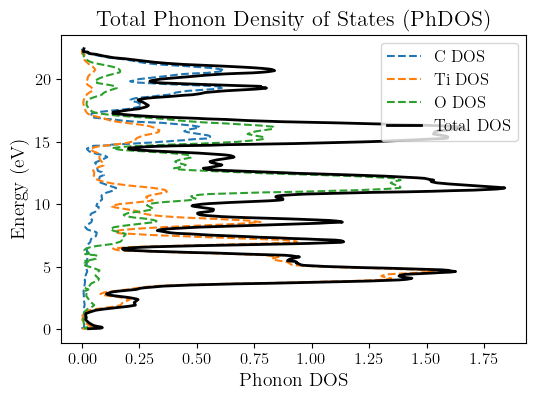

In [8]:
from scipy.interpolate import interp1d

common_y = np.linspace(min(min(C_y), min(Ti_y), min(O_y)), max(max(C_y), max(Ti_y), max(O_y)), 500)

# interpol DOS values
C_interp = interp1d(C_y, C_x, kind='linear', bounds_error=False, fill_value=0)
Ti_interp = interp1d(Ti_y, Ti_x, kind='linear', bounds_error=False, fill_value=0)
O_interp = interp1d(O_y, O_x, kind='linear', bounds_error=False, fill_value=0)

C_x_interp = C_interp(common_y)
Ti_x_interp = Ti_interp(common_y)
O_x_interp = O_interp(common_y)

total_DOS = C_x_interp + Ti_x_interp + O_x_interp

plt.figure(figsize=(6, 4))
common_y = common_y * cm_1_to_THz
plt.plot(C_x_interp, common_y, label="C DOS", linestyle="--")
plt.plot(Ti_x_interp, common_y, label="Ti DOS", linestyle="--")
plt.plot(O_x_interp, common_y, label="O DOS", linestyle="--")
plt.plot(total_DOS, common_y, label="Total DOS", color="black", linewidth=2)

plt.xlabel("Phonon DOS")
plt.ylabel("Energy (eV)")
plt.legend()
plt.title("Total Phonon Density of States (PhDOS)")
plt.show()

### MXene - MACE-MP-0

In [49]:
relaxed_mxene_unit_macemp0 = io.read("structures/mxene_unit_relaxed_macemp0.xyz")
relaxed_mxene_unit_mace_mpa = io.read("structures/relax_mxene_unit_mace.xyz")
relaxed_mxene_unit_omat = io.read("structures/relax_mxene_unit_omat.xyz")

In [128]:
phonons_mxene_mace_mp0 = compute_ph_phdos(relaxed_mxene_unit_macemp0, N_supercell=4, calc = macemp0)

/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_18527/518082095.py:147: DeprecationWarning: PhonopyAtoms.__init__ parameter of pbc is deprecated. It is considered always True.
  phonoatoms = PhonopyAtoms(


/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_18527/3267515824.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


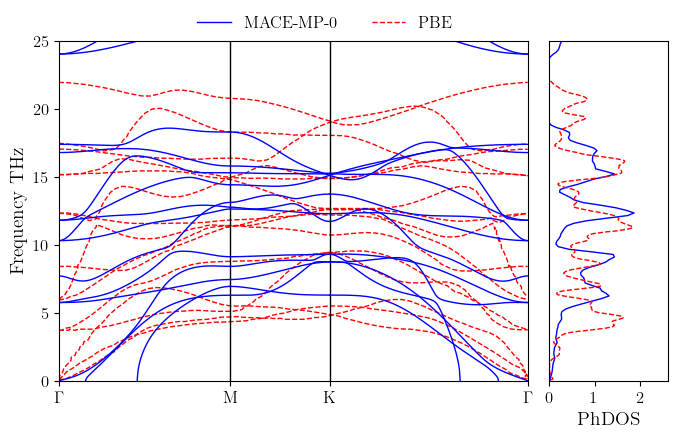

In [205]:
plot_ph_phdos(phonons_mxene_mace_mp0, model= "MACE-MP-0", xlim_dos=(0,2.6), ref_ph=(x_sorted_mxene_ph, y_sorted_mxene_ph), ref_phdos=(total_DOS, common_y), xticks_dos=[0, 1, 2],
              filepath="figures/mxene_phonons_macemp0.png")

### MXene - MACE-MPA-0

In [130]:
phonons_mxene_mace_mpa = compute_ph_phdos(relaxed_mxene_unit_mace_mpa, N_supercell=4, calc = macemp)

/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_18527/518082095.py:147: DeprecationWarning: PhonopyAtoms.__init__ parameter of pbc is deprecated. It is considered always True.
  phonoatoms = PhonopyAtoms(


All frequencies are real. Min Frequency = 0.006430182524167226 THz


/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_18527/3267515824.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


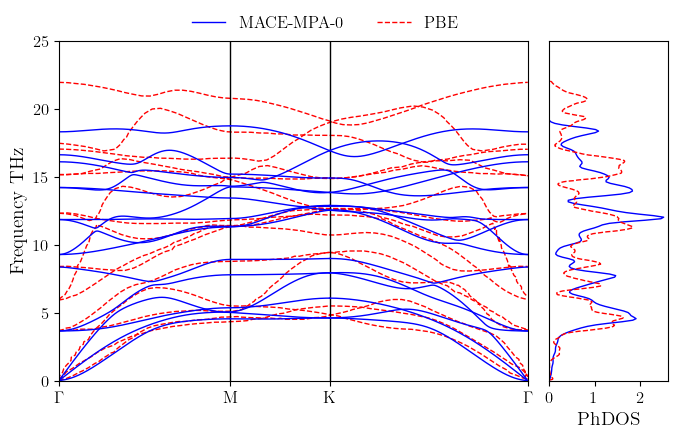

In [206]:
plot_ph_phdos(phonons_mxene_mace_mpa, model= "MACE-MPA-0", xlim_dos=(0,2.6), ref_ph=(x_sorted_mxene_ph, y_sorted_mxene_ph), ref_phdos=(total_DOS, common_y), xticks_dos=[0, 1, 2],
              filepath="figures/mxene_phonons_macempa.png")

### MXene - MACE-OMAT-0

In [132]:
phonons_mxene_omat = compute_ph_phdos(relaxed_mxene_unit_omat, N_supercell=4, calc = macemp_omat)

/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_18527/518082095.py:147: DeprecationWarning: PhonopyAtoms.__init__ parameter of pbc is deprecated. It is considered always True.
  phonoatoms = PhonopyAtoms(


All frequencies are real. Min Frequency = 0.011244736662711132 THz


/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_18527/3267515824.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


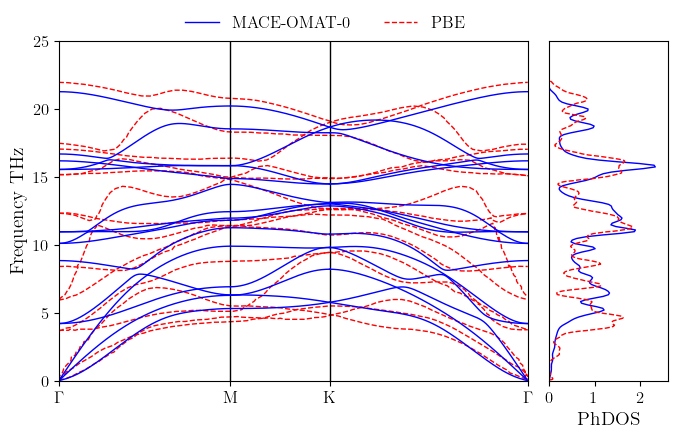

In [207]:
plot_ph_phdos(phonons_mxene_omat, model= "MACE-OMAT-0", xlim_dos=(0,2.6), ref_ph=(x_sorted_mxene_ph, y_sorted_mxene_ph), ref_phdos=(total_DOS, common_y), xticks_dos=[0, 1, 2],
              filepath="figures/mxene_phonons_omat.png")

### Graphene reference data: Phonons

- phonons reference: First-principles calculations of phonon behaviors in graphether: a comparative study with graphene
- phdos reference: Atomic cluster expansion for quantum-accurate large-scale simulations of carbon

In [123]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import glob

# load all ph_mode files (extracted with plot digitiser)
file_pattern = "reference_ph_modes/graphene_ph*.json"
files = sorted(glob.glob(file_pattern), key=lambda x: int(x.split("ph_mode")[-1].split(".json")[0]))

data_graphene = []

for file in files:
    with open(file, 'r') as f:
        data_graphene.append(json.load(f))

values_x_graphene = []
values_y_graphene = []

for dat in data_graphene:
    values_x_graphene.append([i['value'][0] for i in dat['datasetColl'][0]['data']])
    values_y_graphene.append([i['value'][1] for i in dat['datasetColl'][0]['data']])

x_min = [min(band) for band in values_x_graphene]
x_max = [max(band) for band in values_x_graphene]
    
# normalise x_min and x_max to [0, npoints]

# Normalize to range [0, npoints]
x_norm_graphene = [
    [(x - band_min) / (band_max - band_min) * npoints for x in band]
    for band, band_min, band_max in zip(values_x_graphene, x_min, x_max)
]


x_sorted_graphene_ph = []
y_sorted_graphene_ph = []
for mode in range(len(x_norm_graphene)):  
    # Convert lists to NumPy arrays
    x_array = np.array(x_norm_graphene[mode])
    y_array = np.array(values_y_graphene[mode])

    # Get sorting indices
    sorted_indices_graphene_ph = np.argsort(x_array)

    # Append sorted values
    x_sorted_graphene_ph.append(x_array[sorted_indices_graphene_ph])
    y_sorted_graphene_ph.append(y_array[sorted_indices_graphene_ph])


### Graphene reference data: PhDOS

In [82]:
with open("reference_ph_modes/dos_graphene.json", 'r') as f:
    data_dos_graphene = json.load(f)
x_dos_graphene = np.array([i['value'][0] for i in data_dos_graphene['datasetColl'][0]['data']])
y_dos_graphene = np.array([i['value'][1] for i in data_dos_graphene['datasetColl'][0]['data']])

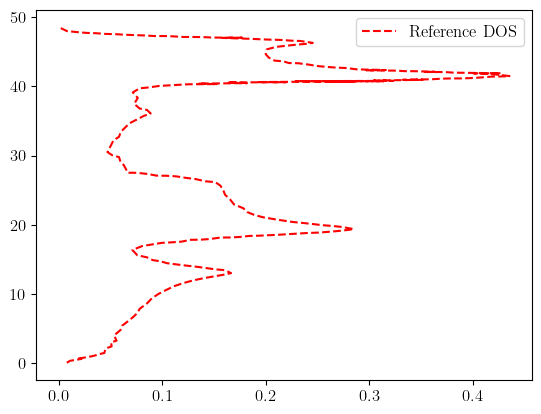

In [147]:
sorted_indices = np.argsort(y_dos_graphene)
x_sorted_dos_graphene = x_dos_graphene[sorted_indices]
y_sorted_dos_graphene = y_dos_graphene[sorted_indices]

plt.plot(x_sorted_dos_graphene, y_sorted_dos_graphene, linestyle="--", markersize=1, color="red", label="Reference DOS")
plt.legend()
plt.show()

### Graphene - MACE-MP-0

In [134]:
graphene_atoms_macemp0 = build.graphene(formula='C2', a=2.46, size=(1, 1, 1), vacuum=3.5)
graphene_atoms_macemp0.calc = macemp0
phonons_graphene_mp0 = compute_ph_phdos(graphene_atoms_macemp0, N_supercell=5, calc = macemp0, sigma_dos=0.4)

/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_18527/518082095.py:147: DeprecationWarning: PhonopyAtoms.__init__ parameter of pbc is deprecated. It is considered always True.
  phonoatoms = PhonopyAtoms(
FC2 calculation: C2:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_18527/3267515824.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


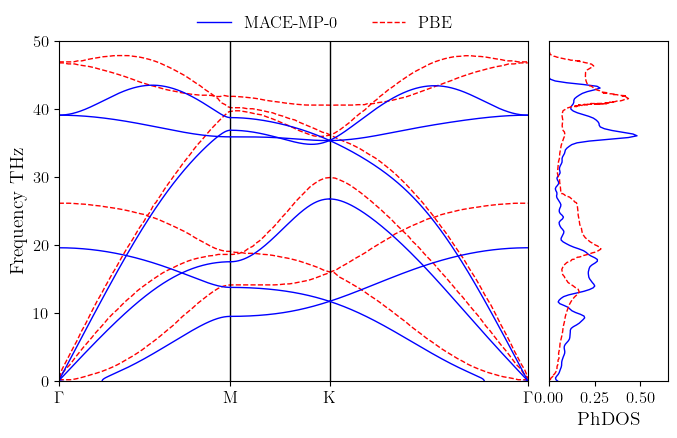

In [208]:
plot_ph_phdos(phonons_graphene_mp0, model= "MACE-MP-0", xlim_dos=(0,0.65), ref_ph=(x_sorted_graphene_ph, y_sorted_graphene_ph), ref_phdos=(x_sorted_dos_graphene, y_sorted_dos_graphene), ylim=(0, 50), xticks_dos=[0, 0.25, 0.5],
              filepath="figures/graphene_phonons_macemp0.png")

### Graphene - MACE-MPA-0

In [136]:
graphene_atoms_macempa = build.graphene(formula='C2', a=2.46, size=(1, 1, 1), vacuum=3.5)
graphene_atoms_macempa.calc = macemp
phonons_graphene_mpa= compute_ph_phdos(graphene_atoms_macempa, N_supercell=5, calc = macemp, sigma_dos=0.4)

/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_18527/518082095.py:147: DeprecationWarning: PhonopyAtoms.__init__ parameter of pbc is deprecated. It is considered always True.
  phonoatoms = PhonopyAtoms(


All frequencies are real. Min Frequency = 0.0198214479408716 THz


/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_18527/3267515824.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


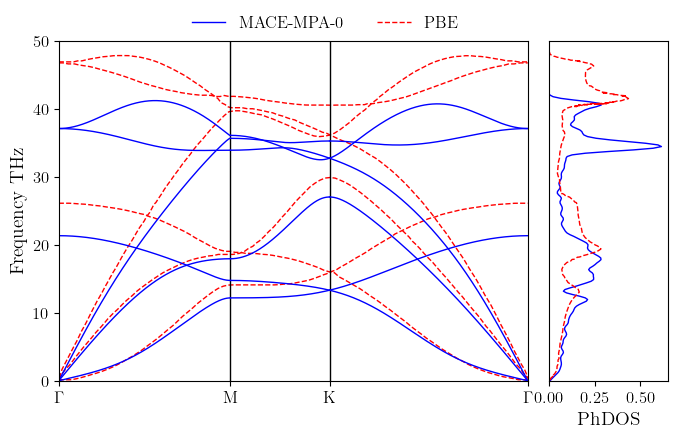

In [209]:
plot_ph_phdos(phonons_graphene_mpa, model= "MACE-MPA-0", xlim_dos=(0,0.65), ref_ph=(x_sorted_graphene_ph, y_sorted_graphene_ph), ref_phdos=(x_sorted_dos_graphene, y_sorted_dos_graphene), ylim=(0, 50), xticks_dos=[0, 0.25, 0.5],
              filepath="figures/graphene_phonons_macempa.png")

### Graphene - MACE-OMAT-0

In [138]:
graphene_atoms_mace_omat = build.graphene(formula='C2', a=2.46, size=(1, 1, 1), vacuum=3.5)
graphene_atoms_mace_omat.calc = macemp_omat
phonons_graphene_omat= compute_ph_phdos(graphene_atoms_mace_omat, N_supercell=5, calc = macemp_omat, sigma_dos=0.4)

/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_18527/518082095.py:147: DeprecationWarning: PhonopyAtoms.__init__ parameter of pbc is deprecated. It is considered always True.
  phonoatoms = PhonopyAtoms(


All frequencies are real. Min Frequency = -0.010398011786458928 THz


/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_18527/3267515824.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


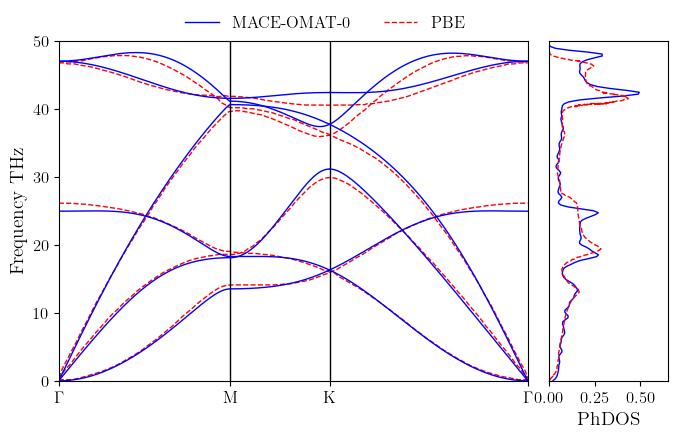

In [210]:
plot_ph_phdos(phonons_graphene_omat, model= "MACE-OMAT-0", xlim_dos=(0,0.65), ref_ph=(x_sorted_graphene_ph, y_sorted_graphene_ph), ref_phdos=(x_sorted_dos_graphene, y_sorted_dos_graphene), ylim=(0, 50), xticks_dos=[0, 0.25, 0.5],
              filepath="figures/graphene_phonons_omat.png")